This notebook makes predictions using Neural Networks \\
 \\
How to use it: \\
 \\
Run all cells from "Importation", "Model", "Get data from files" and "Useful functions" \\
 \\
In the "Main" part, run "Columns and files" \\
 \\
In the "Build X and y" Section of "Main", choose the value of the parameters and run the section to build the dataset. \\
 \\
"Train" and "Test" should be run respectively for the cross validation and the testing after choosing the value of the parameters. \\

#Importation

In [ ]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
import numpy as np
from sklearn import preprocessing
import datetime as dt
import pandas as pd
!pip install dpkt
import dpkt
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 KB 9.4 MB/s eta 0:00:00


#Model

##Neural Networks

In [ ]:
# nn_classification: scales the data, create a NN classification model and makes prediction

def nn_classification( solv, a, lay, Xtrain, ytrain, Xtest ):
    scaler = preprocessing.StandardScaler().fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    clf = MLPClassifier(solver=solv, alpha=a, hidden_layer_sizes=lay, random_state=1,max_iter=10000)
    clf.fit(Xtrain,ytrain)
    return clf.predict(Xtest)

# nn_regression: scales the data, create a NN regression model and makes prediction

def nn_regression( solv, a, lay, Xtrain, ytrain, Xtest ):
    Xtr=Xtrain.copy()
    ytr=ytrain.copy()
    Xte=Xtest.copy()
    scaler = preprocessing.StandardScaler().fit(Xtr)
    Xtr = scaler.transform(Xtr)
    Xte = scaler.transform(Xte)
    Mi=min(ytrain)
    Ma=max(ytrain)
    #scalery = preprocessing.MinMaxScaler().fit(ytr.reshape(-1,1))
    #y = scalery.transform(ytr.reshape(-1,1))
    #for i in range(len(ytr)):
    #  ytr[i]=y[i][0]
    regr = MLPRegressor(random_state=1, max_iter=50000, hidden_layer_sizes=lay, alpha=a, solver=solv, learning_rate_init=1e-2, shuffle=False).fit(Xtr, ytr)

    ypred = regr.predict(Xte)
    #ypred=ypred*(Ma-Mi)+Mi
    return ypred

##Cross Validation

In [ ]:
# performs a time series cross validation

def cv_time(X,y,solv,a,lay,error,c):

  # Create the 5 different X and y to do the cross validation

  (n,m)=np.shape(X)
  ncv=int(n/10)           # divide the data into 10 parts (0 to 9)

  Xtrain1=X[0:5*ncv,:]    # cross 1:
  ytrain1=y[0:5*ncv]      #         train: parts 0 to 4
  Xval1=X[5*ncv:6*ncv,:]  #         validation: part 5
  yval1=y[5*ncv:6*ncv]

  Xtrain2=X[0:6*ncv,:]    # cross 2:
  ytrain2=y[0:6*ncv]      #         train: parts 0 to 5
  Xval2=X[6*ncv:7*ncv,:]  #         validation: part 6
  yval2=y[6*ncv:7*ncv]

  Xtrain3=X[0:7*ncv,:]    # cross 3:
  ytrain3=y[0:7*ncv]      #         train: parts 0 to 6
  Xval3=X[7*ncv:8*ncv,:]  #         validation: part 7
  yval3=y[7*ncv:8*ncv]

  Xtrain4=X[0:8*ncv,:]    # cross 4:
  ytrain4=y[0:8*ncv]      #         train: parts 0 to 7
  Xval4=X[8*ncv:9*ncv,:]  #         validation: part 8
  yval4=y[8*ncv:9*ncv]

  Xtrain5=X[0:9*ncv,:]    # cross 5:
  ytrain5=y[0:9*ncv]      #         train: parts 0 to 8
  Xval5=X[9*ncv:n,:]      #         validation: part 9
  yval5=y[9*ncv:n]

  # Make the predictions and calculate the error for each cross

  e1 = CV(solv, a, lay, Xtrain1, ytrain1, Xval1, yval1, error, c)
  e2 = CV(solv, a, lay, Xtrain2, ytrain2, Xval2, yval2, error, c)
  e3 = CV(solv, a, lay, Xtrain3, ytrain3, Xval3, yval3, error, c)
  e4 = CV(solv, a, lay, Xtrain4, ytrain4, Xval4, yval4, error, c)
  e5 = CV(solv, a, lay, Xtrain5, ytrain5, Xval5, yval5, error, c)

  return (e1+e2+e3+e4+e5)/5

def CV(solv, a, lay, Xtrain, ytrain, Xval, yval, error, c):
  if c==1:
    ypred=nn_classification(solv,a,lay,Xtrain,ytrain,Xval)
  else:
    ypred=nn_regression(solv,a,lay,Xtrain,ytrain,Xval)
  e=choice_err(ypred, yval, error)
  return e

##Error

In [ ]:
def choice_err(y1, y2, c):
  if c==1:
    return F1score(y1, y2)
  if c==2:
    return mae(y1, y2)
  if c==60:
    return mae_alpha(y1, y2, 60)
  if c==30:
    return mae_alpha(y1, y2, 30)
  if c==3:
    return nz_mae(y1, y2, 100)

def F1score(ypred,y):
    tp=0
    fp=0
    tn=0
    fn=0
    for i in range(len(y)):
        if y[i]==ypred[i]:
            if y[i]==0:
                tn=tn+1
            else:
                tp=tp+1
        else:
            if y[i]==0:
                fp=fp+1
            else:
                fn=fn+1
    if tp==0:
        return 0
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=2*precision*recall/(precision+recall)
    return f1

def mae(ypred, y):
    s=0
    for i in range(len(y)):
        s=s+abs(y[i]-ypred[i])
    return s/len(y)

def mae_alpha(ypred, y, alpha):
  s=0
  for i in range(len(y)):
    a = min(y[i],alpha)
    b = min(ypred[i],alpha)
    b = max(0,b)
    s = s+abs(a-b)
  return s/len(y)

def nz_mae(ypred, y, weight):
  s=0
  for i in range(len(y)):
    if y[i]==0:
      s = s + abs(ypred[i])
    else:
      s = s + weight*abs(ypred[i]-y[i])
  return s/len(y)

#Get data from files

##Packet Loss

In [ ]:
# selects the data we want in the dataset to predict the number of packet losses
# using regression (reg) and classification (class)

def Xy_loss_reg(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n-1,7))
  Y=[]
  for i in range(n-1):
    X[i,0]=p5[i+1]
    X[i,1]=q5[i+1]
    X[i,2]=s[i+1]
    X[i,3]=rx2[i+1]
    X[i,4]=tx2[i+1]
    X[i,5]=latency[i+1]
    X[i,6]=loss[i]
    Y.append(loss[i+1])
  return X,Y

def Xy_loss_reg2(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  loss2=transf_nbloss(loss)
  (n,)=np.shape(s)
  X=np.zeros((n,4))
  Y=[]
  for i in range(n):
    X[i,0]=p5[i]
    X[i,1]=q5[i]
    X[i,2]=s[i]
    X[i,3]=latency[i]
    Y.append(loss2[i])
  return X,Y

def Xy_loss_class(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n-1,7))
  Y=[]
  for i in range(n-1):
    X[i,0]=p5[i+1]
    X[i,1]=q5[i+1]
    X[i,2]=s[i+1]
    X[i,3]=rx2[i+1]
    X[i,4]=tx2[i+1]
    X[i,5]=latency[i+1]
    if loss[i]==0:
      X[i,6]=loss[i]
    else:
      X[i,6]=1
    if loss[i+1]==0:
      Y.append(loss[i+1])
    else:
      Y.append(1)
  return X,Y

##Latency

In [ ]:
# selects the data we want in the dataset to predict the latency
# with SigStrength (Xy_lat) and without (Xy_lat2)

def Xy_lat(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n-1,9))
  Y=[]
  for i in range(n-1):
    X[i,0]=p5[i+1]
    X[i,1]=q5[i+1]
    if cc[i+1]=='-' and csv=='3232_6.csv':
      cc[i+1]=-83
    X[i,2]=cc[i+1]
    X[i,3]=nc[i+1]
    X[i,4]=s[i+1]
    X[i,5]=rx2[i+1]
    X[i,6]=tx2[i+1]
    X[i,7]=loss[i+1]
    X[i,8]=latency[i]
    Y.append(latency[i+1])
  return X,Y

def Xy_lat2(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n-1,7))
  Y=[]
  for i in range(n-1):
    X[i,0]=p5[i+1]
    X[i,1]=q5[i+1]
    X[i,2]=s[i+1]
    X[i,3]=rx2[i+1]
    X[i,4]=tx2[i+1]
    X[i,5]=loss[i+1]
    X[i,6]=latency[i]
    Y.append(latency[i+1])
  return X,Y

##Base Station

###Presence of change (0 or 1)

In [ ]:
# selects the data we want in the dataset to predict if there is a change of base station

def Xy_change(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n-1,10))
  Y=[]
  for i in range(n-1):
    X[i,0]=p[i+1]
    X[i,1]=q[i+1]
    X[i,2]=cc[i+1]
    X[i,3]=nc[i+1]
    X[i,4]=s[i+1]
    X[i,5]=rx2[i+1]
    X[i,6]=tx2[i+1]
    X[i,7]=loss[i+1]
    X[i,8]=latency[i+1]
    X[i,9]=PCI[i]
    Y.append(PCI[i+1])
  return X,Y

###Time before the next change

In [ ]:
# selects the data we want in the dataset to predict the time before the next change of base station
# with SigStrength (Xy_time) and without (Xy_time2)

def Xy_time(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  time_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = transf_pci(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(time_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n,9))
  Y=[]
  for i in range(n):
    X[i,0]=p[i]
    X[i,1]=q[i]
    if cc[i]=='-' and csv=='3232_6.csv':
      cc[i]=-83
    X[i,2]=cc[i]
    X[i,3]=nc[i]
    X[i,4]=s[i]
    X[i,5]=rx2[i]
    X[i,6]=tx2[i]
    X[i,7]=loss[i]
    X[i,8]=latency[i]
    Y.append(PCI[i])
  return X,Y

def Xy_time2(pcap,csv):
  loss, latency = get_loss_latency(pcap)
  change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = get_datacsv(csv)
  time_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg = transf_pci(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg)
  PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg = transf_data(time_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg)
  (n,)=np.shape(s)
  X=np.zeros((n,7))
  Y=[]
  for i in range(n):
    X[i,0]=p[i]
    X[i,1]=q[i]
    X[i,2]=s[i]
    X[i,3]=rx2[i]
    X[i,4]=tx2[i]
    X[i,5]=loss[i]
    X[i,6]=latency[i]
    Y.append(PCI[i])
  return X,Y

##Get Loss and Latency from pcap files

In [ ]:
def get_loss_latency(file):     # returns the packet loss and latency datas
    timestamp_list = []

    f = open(file, "rb")
    pcap = dpkt.pcap.Reader(f)

    for ts, buf in pcap:
        if len(buf) != 292:
            continue

        #Extract payload of the UDP packet
        #---------------------------------
        eth = dpkt.ethernet.Ethernet(buf)
        ip = eth.ip
        udp = ip.data

        if len(udp) == 250+8:       # We set the payload length to be 250 in iperf, so here we set the length checking to be 250 + 8
            #                       #當 packet payload 大小改變時，此大小需要修正

            datetimedec = int(udp.data.hex()[0:8], 16)
            microsec = int(udp.data.hex()[8:16], 16)

            seq = int(udp.data.hex()[16:24], 16)

            if seq == 1:            #可能在做實驗時，會有 iperf3 重新開始的狀況。
                timestamp_list = []

            timestamp_list.append((ts, datetimedec, microsec, seq))

    timestamp_list = sorted(timestamp_list, key = lambda v : v[3])


    #Checking packet loss...
    #----------------------------------------------
    pointer = 1
    timestamp_store = None
    loss_time_list = []

    for timestamp in timestamp_list:
        if timestamp[3] == pointer:
            timestamp_store = timestamp
        else:
            if timestamp_store == None:
                continue
            loss_linspace = np.linspace(timestamp_store, timestamp, timestamp[3]-pointer+2)

            for i in loss_linspace:
                lost_time = dt.datetime.utcfromtimestamp(i[1]+i[2]/1000000.) + dt.timedelta(hours=8) #for pcap packets, the timestamps are needed to add 8 hours (timezone)
                loss_time_list.append(lost_time)


        pointer = timestamp[3] + 1


    #x and y stands for the timestamp (x) and the one-way latency (y) on the timestamp, respectively
    #----------------------------------------------
    x = []
    y = []
    for i in range(len(timestamp_list)):
        transmitted_time = dt.datetime.utcfromtimestamp(timestamp_list[i][1] + timestamp_list[i][2]/1000000.) + dt.timedelta(seconds=3600*8) #for pcap packets, the timestamps are needed to add 8 hours (timezone)
        x.append(transmitted_time)
        y.append( ( timestamp_list[i][0]+3600*8 - (timestamp_list[i][1] + timestamp_list[i][2]/1000000. + 3600*8) ) * 1000 )

    latency = [x, y]

    res_loss = transf_loss(loss_time_list)
    res_latency = transf_latency(latency)

    return res_loss, res_latency

def transf_loss(loss):      # counts the number of packet losses for every second when there is at least 1 packet loss
    nloss=len(loss)
    count_loss=[]
    time2=''
    k=-1
    for i in range(nloss):
        dateloss=str(loss[i])
        time=''
        for j in range(8):
            a=dateloss[11+j]
            time=time+a
        if time!=time2:                 # if the time of the new packet loss is not the same as the previous one
            count_loss.append([time,1]) # we add a new element with the time and the number of packet loss (1)
            k=k+1
        else:                                     # else
            count_loss[k][1]=count_loss[k][1]+1   # we update the number of packet losses for that time (+1)
        time2=time

    return count_loss

def transf_latency(latency):  # returns the average of the latency at each second
    la1=latency[0]
    la2=latency[1]
    nlatency=len(la1)
    avg_latency=[]
    time2=''
    k=-1
    s=0
    c=0
    for i in range(nlatency):
        datelatency=str(la1[i])
        valuelatency=la2[i]
        time=''
        for j in range(8):
            a=datelatency[11+j]
            time=time+a
        if time!=time2:                   # if the new latency is not in the same second as the previous one
            avg_latency.append([time,0])    # create a new element with the new time
            if k>=0:
                avg_latency[k][1]=s/c       # puts the average of the latency of the previous second in the previous element
            k=k+1
            s=valuelatency                  # initialize the new sum
            c=1                             # initialize c to 1 (counts the number of element in each second)
        else:                             # else
            s=s+valuelatency                # update the sum
            c=c+1                           # update c
        time2=time

    avg_latency[k][1]=s/c
    return(avg_latency)

def transf_loss_latency(loss,latency):  # puts loss=0 every time latency is collected and there is no packet loss
    la=[]
    lo=[]
    t=[]
    k=0
    for i in range(len(latency)):
        la.append(latency[i][1])
        t.append(transf_time(latency[i][0]))
        if k<len(loss):
            if latency[i][0]==loss[k][0]:
                lo.append(loss[k][1])
                k=k+1
            else:
                lo.append(0)
        else:
            lo.append(0)
    return t,lo,la

##Get data from csv files

In [ ]:
def get_datacsv(file):      # collects the data from the csv file
    data = pd.read_csv(file)
    n=len(data)
    change_PCI=[]
    rsrp=[]
    rsrq=[]
    rsrp5=[]
    rsrq5=[]
    speed=[]
    rx=[]
    tx=[]
    current_cell=[]
    next_cell=[]
    fiveg=[]
    PCI=0
    s1=0
    s2=0
    for i in range(n):
        time=''
        for j in range(8):
            time=time+data['Date'][i][j+9]

        if PCI!=data['PCI'][i]:
            c=1
            PCI=data['PCI'][i]
        else:
            c=0
        change_PCI.append([time,c])
        if data['NR_SSRSRP'][i]=='-':
            fiveg.append([time,0])
            s1=s1+1
            cor=data['LTE_RSRP'][i]
            coq=data['LTE_RSRQ'][i]
        else:
            fiveg.append([time,1])
            s2=s2+1
            cor=data['NR_SSRSRP'][i]
            coq=data['NR_SSRSRQ'][i]

        rsrp5.append([time,cor])
        rsrq5.append([time,coq])

        rsrp.append([time,data['LTE_RSRP'][i]])
        rsrq.append([time,data['LTE_RSRQ'][i]])

        current_cell.append([time,data['SigStrength'][i]])
        if data['SigStrength1'][i]=='-':
            nc=100
        else:
            nc=data['SigStrength1'][i]
        next_cell.append([time,nc])

        speed.append([time,data['GPSSpeed'][i]])

        rx.append([time,data['RxRate'][i]])
        tx.append([time,data['TxRate'][i]])
    return change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg


# transf_pci is used to build the features when we want to predict the time before the next change of base station
def transf_pci(PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg):
    time_PCI=[]
    p=[]
    q=[]
    p5=[]
    q5=[]
    cc=[]
    nc=[]
    s=[]
    rr=[]
    tt=[]
    fg=[]
    n=len(PCI)
    k=0
    time=0
    for i in range(n):          # go from the the end of the list PCI to the 1st element
        c=PCI[n-1-i][1]
        t=PCI[n-1-i][0]
        if c==1:                # if there is a change
            time=transf_time(t) # we set time to the time of the change
            time2=0
            k=1   # after the first change we see (so the last one in a chronological order), we put k=1
        else:
            time2=time-transf_time(t)
        if k==1:                          # if k==1, we take the values of the fatures
            time_PCI.append([t,time2])    # I did that to ignore the moment after the last change
            p.append(rsrp[n-1-i])         # as we don't know the time before the next change
            q.append(rsrq[n-1-i])
            p5.append(rsrp5[n-1-i])
            q5.append(rsrq5[n-1-i])
            cc.append(current_cell[n-1-i])
            nc.append(next_cell[n-1-i])
            s.append(speed[n-1-i])
            rr.append(rx[n-1-i])
            tt.append(tx[n-1-i])
            fg.append(fiveg[n-1-i])
    n2=len(time_PCI)
    time_PCI2=[]
    p2=[]
    q2=[]
    p52=[]
    q52=[]
    cc2=[]
    nc2=[]
    s2=[]
    rr2=[]
    tt2=[]
    fg2=[]
    for i in range(n2):
        time_PCI2.append(time_PCI[n2-1-i])
        p2.append(p[n2-1-i])
        q2.append(q[n2-1-i])
        p52.append(p5[n2-1-i])
        q52.append(q5[n2-1-i])
        cc2.append(cc[n2-1-i])
        nc2.append(nc[n2-1-i])
        s2.append(s[n2-1-i])
        rr2.append(rr[n2-1-i])
        tt2.append(tt[n2-1-i])
        fg2.append(fg[n2-1-i])
    return time_PCI2,p2,q2,p52,q52,cc2,nc2,s2,rr2,tt2,fg2

def transf_data(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, loss, latency, fiveg):
    t,lo,la=transf_loss_latency(loss,latency)
    return transf(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg, t, lo, la)

def transf_time(t):       # transforms a time in string to an int
    hours=int(t[0]+t[1])
    minutes=int(t[3]+t[4])
    seconds=int(t[6]+t[7])
    t2=seconds+60*minutes+3600*hours
    return t2


# csv and pcap files don't have the same beginning and finishing collecting times, and csv files miss some times
# transf takes the features at the times when the datas from the csv files AND those from pcap are collected
def transf(change_PCI, rsrp, rsrq, rsrp5, rsrq5, current_cell, next_cell, speed, rx, tx, fiveg, t, lo, la):
    PCI=[]
    p=[]
    q=[]
    p5=[]
    q5=[]
    cc=[]
    nc=[]
    s=[]
    rx2=[]
    tx2=[]
    loss=[]
    latency=[]
    fg=[]
    t1,t2,c,ia,ib=check(t[0],transf_time(rx[0][0]),0,0)
    x=0
    while x==0:
        if t1==t2:                          # if at that iteration, the time from both list are the same:
            PCI.append(change_PCI[ib][1])   # take all features
            p.append(rsrp[ib][1])
            q.append(rsrq[ib][1])
            p5.append(rsrp5[ib][1])
            q5.append(rsrq5[ib][1])
            cc.append(current_cell[ib][1])
            nc.append(next_cell[ib][1])
            s.append(speed[ib][1])
            rx2.append(rx[ib][1])
            tx2.append(tx[ib][1])
            fg.append(fiveg[ib][1])
            loss.append(lo[ia])
            latency.append(la[ia])

            if (ib+1>=len(rx)) or (ia+1>=len(la)):
                return PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg

            t1,t2,c,ia,ib=check(t[ia+1],transf_time(rx[ib+1][0]),ia+1,ib+1)
            # check the smaller time for the next elements of both lists

        else:   # if the times are not the same
            t1,t2,c,ia,ib=check(t[ia],transf_time(rx[ib][0]),ia,ib)
            # check which time is smaller

            if (c==1 and ib+1>=len(rx)) or (c==2 and ia+1>=len(la)):
                return PCI,p,q,p5,q5,cc,nc,s,rx2,tx2,loss,latency,fg

            if c==1:  # if the time of csv files is smaller
                # take the next elements (time and index) of the csv list
                t1,ib=updatet1(transf_time(rx[ib+1][0]),ib)

            if c==2:  # if the time of pcap files is smaller
                # take the next elements of the pcap list
                t1,ia=updatet1(t[ia+1],ia)

def check(a,b,ia,ib):
    if a>=b:
        t1=b            # puts the smaller time to t1
        t2=a
        c=1             # c=1 when the smaller time is b (the time of csv files in transf)
    else:
        t1=a
        t2=b
        c=2             # c==2 when the smaller time is a (the time of pcap files in transf)
    return t1,t2,c,ia,ib

def updatet1(a,i):
    t=a
    i=i+1
    return t,i

# transf_nbloss transforms the loss features to have "enlarged peaks", to have less values =0
def transf_nbloss(loss):
  loss2=loss.copy()
  n=len(loss)
  for i in range(n):
    if loss[i]>0:
      v=loss[i]
      k=0
      while v>=0.01:
        loss2,v=update_Xd(loss2,i-k,v)
        loss2,v=update_Xu(loss2,i+k,v)
        k=k+1
  return loss2

def update_Xd(X,k,v):
  if k-1>=0:
    if X[k-1]<0.95*v:
      X[k-1]=0.95*v     # the element before the non-zero value is equal to 0.95*the value
  return X,v

def update_Xu(X,k,v):
  if k+1<len(X):
    if X[k+1]<0.95*v:
      X[k+1]=0.95*v     # the element after the non-zero value is equal to 0.95*the value
  return X,0.95*v

#Useful Functions

##Dataset

In [ ]:
# create the dataset

def dataset(pcap,csv,col,c):
    if c==0:
        X,y = Xy_change(pcap[0],csv[0])
    if c==3:
        X,y = Xy_lat(pcap[0],csv[0])
    if c==4:
        X,y = Xy_lat2(pcap[0],csv[0])
    if c==5:
        X,y = Xy_loss_reg(pcap[0],csv[0])
    if c==6:
        X,y = Xy_loss_class(pcap[0],csv[0])
    if c==1:
        X,y = Xy_time(pcap[0],csv[0])
    if c==2:
        X,y = Xy_time2(pcap[0],csv[0])
    if c==7:
        X,y = Xy_loss_reg(pcap[0],csv[0])
    df=pd.DataFrame(X)
    dyy=pd.DataFrame(y)
    for i in range(1,len(csv)):
        if c==0:
            X1,y1 = Xy_change(pcap[i],csv[i])
        if c==3:
            X1,y1 = Xy_lat(pcap[i],csv[i])
        if c==4:
            X1,y1 = Xy_lat2(pcap[i],csv[i])
        if c==5:
            X1,y1 = Xy_loss_reg(pcap[i],csv[i])
        if c==6:
            X1,y1 = Xy_loss_class(pcap[i],csv[i])
        if c==1:
            X1,y1 = Xy_time(pcap[i],csv[i])
        if c==2:
            X1,y1 = Xy_time2(pcap[i],csv[i])
        if c==5:
            X1,y1 = Xy_loss_reg(pcap[i],csv[i])
        X1d=pd.DataFrame(X1)
        y1d=pd.DataFrame(y1)
        df=pd.concat([df,X1d], ignore_index=True)
        dyy=pd.concat([dyy,y1d])

    df.columns=col

    dyy.columns=['y']
    dy=dyy['y']

    # Divide the dataset into training and testing sets

    lim=0.80
    df1=df.iloc[0:int(len(dy)*lim)]
    df2=df.iloc[int(len(dy)*lim):len(dy)]
    dy1=dy.iloc[0:int(len(dy)*lim)]
    dy2=dy.iloc[int(len(dy)*lim):len(dy)]

    Xtrain=df1.to_numpy()
    Xtest=df2.to_numpy()
    ytrain=dy1.to_numpy()
    ytest=dy2.to_numpy()

    return Xtrain,ytrain,Xtest,ytest

##Test

In [ ]:
def test(Xtrain,ytrain,Xtest,ytest,alpha,layer,solv,model,time,error):
  if model==0:
    ypred = nn_regression(solv,alpha,layer,Xtrain,ytrain,Xtest)
  else:
    ypred = nn_classification(solv,alpha,layer,Xtrain,ytrain,Xtest)

  t=[]
  if time==1:
    t1=-1
    k=0
    for i in range(len(ytest)):
        if t1==-1:
            t.append(i)
            t1=ytest[i]
        else:
            a=t1-ytest[i]
            if a>0:
                k=k+a
                t.append(k)
            else:
                k=k+1
                t.append(k)
            t1=ytest[i]
  else:
    for i in range(len(ytest)):
        t.append(i)

  e = choice_err(ypred, ytest, error)

  return t,ypred,e

#Main

##Columns and files

In [ ]:
pcap3231 = ["3231_1.pcap","3231_2.pcap","3231_3.pcap","3231_4.pcap","3231_5.pcap","3231_6.pcap"]
csv3231 = ["3231_1.csv","3231_2.csv","3231_3.csv","3231_4.csv","3231_5.csv","3231_6.csv"]

pcap0929 = ["0929_1.pcap","0929_2.pcap","0929_3.pcap","0929_4.pcap"]
csv0929 = ["0929_1.csv","0929_2.csv","0929_3.csv","0929_4.csv"]

pcap3232 = ["3232_1.pcap","3232_2.pcap","3232_3.pcap","3232_4.pcap","3232_5.pcap","3232_6.pcap"]
csv3232 = ["3232_1.csv","3232_2.csv","3232_3.csv","3232_4.csv","3232_5.csv","3232_6.csv"]

pcapfile = [pcap3231,pcap3232,pcap0929]
csvfile = [csv3231,csv3232,csv0929]

col_loss_class = ['RSRP', 'RSRQ', 'Speed', 'Rx', 'Tx', 'Latency', 'loss01']
col_loss_reg = ['RSRP', 'RSRQ', 'Speed', 'Rx', 'Tx', 'Latency', 'loss']
col_loss2 = ['RSRP', 'RSRQ', 'Speed', 'Latency']

col_lat = ['RSRP', 'RSRQ', 'Current cell', 'Next cell', 'Speed', 'Rx', 'Tx', 'Packet loss','Latency']
col_lat2 = ['RSRP', 'RSRQ', 'Speed', 'Rx', 'Tx', 'Packet loss','Latency']

col_change = ['RSRP', 'RSRQ', 'Current cell', 'Next cell', 'Speed', 'Rx', 'Tx', 'Packet loss', 'Latency','Change']
col_time = ['RSRP', 'RSRQ', 'Current cell', 'Next cell', 'Speed', 'Rx', 'Tx', 'Packet loss', 'Latency']
col_time2 = ['RSRP', 'RSRQ', 'Speed', 'Rx', 'Tx', 'Packet loss', 'Latency']

col = [col_change, col_time, col_time2, col_lat, col_lat2, col_loss_reg, col_loss_class, col_loss2]

##Build X and y

In [ ]:
data = 0   # 0=dataset1 - 1=dataset2 - 2=dataset3
c = 3
# 0=change of base station - 1=time before change - 2=time without SigStrength - 3=latency - 4=latency without SigStrength -
# 5=Loss with regression - 6=Loss with classification - 7=Loss regression with enlarged peaks

Xtrain,ytrain,Xtest,ytest = dataset(pcapfile[data],csvfile[data],col[c], c)

##Stat

In [ ]:
rsrp=[]
rsrq=[]
cc=[]
nc=[]
speed=[]
rx=[]
tx=[]
loss=[]
lat=[]
for i in range(len(Xtrain)):
  rsrp.append(Xtrain[i][0])
  rsrq.append(Xtrain[i][1])
  cc.append(Xtrain[i][2])
  nc.append(Xtrain[i][3])
  speed.append(Xtrain[i][4])
  rx.append(Xtrain[i][5])
  tx.append(Xtrain[i][6])
  loss.append(Xtrain[i][7])
  lat.append(Xtrain[i][8])

In [ ]:
from scipy.stats import pearsonr, spearmanr
f=[rsrp,rsrq,cc,nc,speed,rx,tx,loss,lat]
pear=np.zeros((9,9))
spear=np.zeros((9,9))
for i in range(9):
  for j in range(9):
    corr, _ = pearsonr(f[i], f[j])
    corr2, _ = spearmanr(f[i], f[j])
    pear[i,j]=corr
    spear[i,j]=corr2
spear

array([[ 1.00000000e+00,  2.73323231e-01,  3.88847952e-01,
         4.78538779e-01,  1.49221296e-01, -4.60545105e-02,
        -1.94866101e-02, -3.50767243e-02, -2.21520003e-01],
       [ 2.73323231e-01,  1.00000000e+00,  3.58574354e-02,
         1.37937427e-02,  1.35792350e-01, -6.09105272e-02,
         2.13566582e-02, -7.05053450e-02,  5.04282499e-02],
       [ 3.88847952e-01,  3.58574354e-02,  1.00000000e+00,
         8.36151105e-01,  1.35418288e-01, -3.76052053e-03,
         5.20035790e-02, -2.78660870e-02, -2.67516411e-01],
       [ 4.78538779e-01,  1.37937427e-02,  8.36151105e-01,
         1.00000000e+00,  1.11323976e-01, -2.28130191e-03,
         1.86131903e-02, -1.62767391e-04, -2.31855673e-01],
       [ 1.49221296e-01,  1.35792350e-01,  1.35418288e-01,
         1.11323976e-01,  1.00000000e+00, -6.44559938e-02,
        -3.58948280e-02,  5.95245050e-02,  6.01319527e-02],
       [-4.60545105e-02, -6.09105272e-02, -3.76052053e-03,
        -2.28130191e-03, -6.44559938e-02,  1.000000

##Train

In [ ]:
alpha = [1e-2,1e-3,1e-4,1e-5,1e-6]
layer = 5
error = 2     # 1: F1score - 2: MAE - 3: NZ MAE - 60: MAE 60 - 30: MAE 30
solv = 'lbfgs'
model = 0

for i in range(len(alpha)):
  err = cv_time(Xtrain, ytrain, solv, alpha[i], layer, error, model)

  print(err)

NameError: ignored

##Test

In [ ]:
model = 0     # =0 for regression and =1 for classification
time = 0      # =1 if we predict the time before the change of base station, =0 otherwise
error = 2     # 1: F1score - 2: MAE - 3: NZ MAE - 60: MAE 60 - 30: MAE 30

alpha=1e-2
layer=6

t,ypred,err = test(Xtrain,ytrain,Xtest,ytest,alpha,layer,solv,model,time,error)

err

1.839305337057441

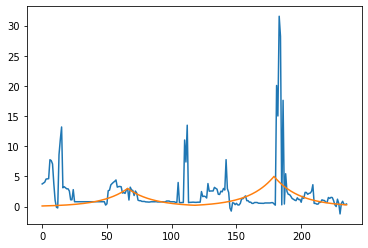

In [ ]:
plt.plot(t,ypred)
plt.plot(t,ytest)